<a href="https://colab.research.google.com/github/matsutakk/Vacancy_Rate/blob/master/ExNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Explable Computation Graph**

## Install torch

In [0]:
!pip install torch

## Import all lib you need

In [0]:
import torch.nn as nn
import torch
import torch.utils
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
import time
import glob
import argparse

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_moons,make_circles
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from datetime import datetime

class Check():
    def __init__(self):
        self.data = []
        self.labels = []
check = Check()

## Make Datasets, Args

In [0]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, X,y,num,transform=None):
        self.data = []
        self.label = []
        self.data_num = num
        for i  in range(X.shape[0]):
            self.data.append(X[i]) 
            self.label.append(y[i]) 

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label =  self.label[idx]

        return out_data, out_label
    
def data_moons(n,noise):
    X = make_moons(n_samples=n, shuffle=True, noise=noise,random_state=10)
    data = X[0]
    label = X[1]
    return data,label

def data_circles(n,noise):
    X = make_circles(n_samples=n, factor=0.5, noise=noise,random_state=10)
    data = X[0]
    label = X[1]
    return data,label

def cancer_data():
  cancer = load_breast_cancer()
  X = torch.from_numpy(cancer.data)
  y = torch.from_numpy(cancer.target)
  return X,y

args = {
        "learning_rate":0.025,
        "learning_rate_retrain":0.025,
        "learning_rate_min":0.001,
        "learning_rate_min_retrain":0.001,
        "batch_size":64,
        "batchsize_retrain":64,
        "momentum":0.9,
        "momentum_retrain":0.9,
        "epoch":10,
        "epoch_retrain":10,
        "seed":2,
        "n_layers":3,
        "weight_decay":3e-4,
        "weight_decay_retrain":3e-4,
        "arch_learning_rate":3e-4,
        "arch_weight_decay":1e-3,
        "grad_clip":5,
        "grad_clip_retrain":5,
        "drop_path_prob":0.3,
        "cutout":False,
        "train_portion":0.5,
        "unrolled":False
        }

## Set up Operations

In [0]:
class OpsServer(nn.Module):
    def __init__(self):
        super(OpsServer, self).__init__()
        self.ops = [
            Log(),
            Exp(),
            Sin(),
            Cos(),
            Square(),
            Identity()
        ]


    def get_ops(self):
        return self.ops
    
class Log(nn.Module):
    def __init__(self):
        super(Log,self).__init__()
    
    def forward(self,x):
        eps=1e-5
        t = F.relu(x)
        t = torch.log(t +eps)
        return t
    
class Exp(nn.Module):
    def __init__(self):
        super(Exp,self).__init__()
    
    def forward(self,x):
        return x.exp()
  
class Sin(nn.Module):
    def __init__(self):
        super(Sin,self).__init__()
    
    def forward(self,x):
        return x.sin()
    
class Cos(nn.Module):
    def __init__(self):
        super(Cos,self).__init__()
    
    def forward(self,x):
        return x.cos()

class Square(nn.Module):
    def __init__(self):
        super(Square, self).__init__()
        
    def forward(self, x):
        return x*x

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

## Main

### Make Datasets

In [0]:
np.random.seed(args["seed"])
torch.manual_seed(args["seed"])
X,y = make_moons(128,0.1)
data_set = MyDataset(X,y,X.shape[0])  
num_train = X.shape[0]
num_classes = 2 
indices = list(range(num_train))
split = int(np.floor(args["train_portion"] * num_train))

train_queue = torch.utils.data.DataLoader(
                data_set, batch_size=args["batch_size"],
                sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[:split]),
              )

valid_queue = torch.utils.data.DataLoader(
                data_set, batch_size=args["batch_size"],
                sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[split:num_train]),
              )

for (X, t), (X_valid, t_valid) in zip(train_queue, valid_queue):
  break

### Model Trian (Architecture Optimization)

In [357]:
print('############### Model Search Phase ###############')
loss_func = nn.CrossEntropyLoss()
model = Network(X.shape[1],num_classes, args["n_layers"], loss_func)
optimizer = torch.optim.SGD(model.parameters(), args["learning_rate"],
                                momentum=args["momentum"],
                                weight_decay=args["weight_decay"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, args["epoch"], eta_min=args["learning_rate_min"])
architect = Architect(model, args)

print("model.alphas")
print(model.alphas)
model = train_search(model, architect, loss_func, optimizer, scheduler,
                         args["epoch"], args["batch_size"], args["grad_clip"],
                         args["unrolled"], train_queue,valid_queue, test_data=None,)

############### Model Search Phase ###############
model.alphas
[tensor([[-0.0002,  0.0009],
        [-0.0011, -0.0004],
        [ 0.0005, -0.0004],
        [-0.0019, -0.0016],
        [-0.0016,  0.0021],
        [ 0.0009, -0.0011]], requires_grad=True), tensor([[-8.6930e-04,  3.8816e-04, -5.3401e-04,  5.1582e-04,  7.0247e-04,
         -1.4918e-03],
        [-3.3901e-06,  1.5199e-03, -2.2927e-04,  2.7920e-05, -8.0173e-05,
         -1.0790e-03],
        [ 2.4757e-03,  2.1716e-04,  6.0517e-04,  1.1904e-03,  4.7970e-04,
         -2.8820e-04],
        [ 6.3959e-04, -7.8639e-04, -4.4501e-04,  2.9332e-04,  8.9640e-04,
          5.7165e-04],
        [-2.3898e-04,  6.9829e-04, -1.3416e-03,  2.7146e-04, -1.4619e-03,
         -2.6729e-04],
        [ 1.6327e-03,  1.3951e-03,  8.7838e-04,  3.3890e-04,  5.0542e-04,
         -6.6812e-04]], requires_grad=True), tensor([[ 1.0752e-03, -5.5282e-04, -9.6053e-04, -4.5583e-04, -2.9367e-04,
          9.2378e-04],
        [-1.2185e-03,  4.1376e-04,  1.0807e-

In [358]:
for i in range(3):
  print(F.softmax(model.arch_parameters()[i]))

tensor([[0.4987, 0.5013],
        [0.4987, 0.5013],
        [0.4992, 0.5008],
        [0.5010, 0.4990],
        [0.4979, 0.5021],
        [0.4994, 0.5006]], grad_fn=<SoftmaxBackward>)
tensor([[0.1663, 0.1669, 0.1669, 0.1670, 0.1664, 0.1665],
        [0.1665, 0.1665, 0.1670, 0.1670, 0.1661, 0.1668],
        [0.1666, 0.1667, 0.1670, 0.1671, 0.1662, 0.1664],
        [0.1664, 0.1668, 0.1666, 0.1665, 0.1670, 0.1669],
        [0.1671, 0.1666, 0.1665, 0.1669, 0.1663, 0.1666],
        [0.1663, 0.1668, 0.1669, 0.1669, 0.1666, 0.1666]],
       grad_fn=<SoftmaxBackward>)
tensor([[0.1666, 0.1665, 0.1669, 0.1669, 0.1662, 0.1670],
        [0.1665, 0.1661, 0.1672, 0.1668, 0.1666, 0.1667],
        [0.1675, 0.1665, 0.1667, 0.1667, 0.1663, 0.1664],
        [0.1663, 0.1668, 0.1667, 0.1667, 0.1666, 0.1669],
        [0.1664, 0.1667, 0.1666, 0.1668, 0.1667, 0.1668],
        [0.1658, 0.1669, 0.1671, 0.1666, 0.1668, 0.1668]],
       grad_fn=<SoftmaxBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


### Model Retrain

In [359]:
trained_alpha = model.arch_parameters()
loss_func = nn.CrossEntropyLoss()
loss_func = loss_func.cuda()
model_retrain = Network_for_retraining(num_classes, args["n_layers"])
model_retrain.build_graph(alphas=trained_alpha)
optimizer = torch.optim.SGD(model_retrain.parameters(), args["learning_rate_retrain"],
                                momentum=args["momentum_retrain"],
                                weight_decay=args["weight_decay_retrain"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, args["epoch_retrain"], eta_min=args["learning_rate_min_retrain"])

model_retrain = train(model_retrain, loss_func, optimizer, scheduler, args["epoch_retrain"],
              args["batchsize_retrain"], args["grad_clip_retrain"], train_queue,
              valid_queue,
              )

############ before calc_forward ##########
tensor([[-5.8374e-01,  8.1194e-01],
        [ 3.1849e-01,  9.4793e-01],
        [ 9.0097e-01,  4.3388e-01],
        [ 5.0000e-01,  8.6603e-01],
        [ 9.6908e-01,  2.4676e-01],
        [ 0.0000e+00,  5.0000e-01],
        [-2.2252e-01,  9.7493e-01],
        [ 1.2225e+00, -4.7493e-01],
        [ 4.1129e-01,  9.1151e-01],
        [-9.2148e-01,  3.8843e-01],
        [ 9.9031e-02,  6.6116e-02],
        [ 5.8871e-01, -4.1151e-01],
        [ 2.2252e-01,  9.7493e-01],
        [ 4.5745e-01, -3.4003e-01],
        [ 1.0000e+00,  0.0000e+00],
        [-6.2349e-01,  7.8183e-01],
        [ 1.8262e+00, -6.3320e-02],
        [-8.7822e-01,  4.7825e-01],
        [ 6.2349e-01,  7.8183e-01],
        [-7.3305e-01,  6.8017e-01],
        [ 9.8883e-01,  1.4904e-01],
        [-9.3969e-01,  3.4202e-01],
        [ 3.6534e-01,  9.3087e-01],
        [ 1.2434e-01,  9.9224e-01],
        [ 8.2635e-01, -4.8481e-01],
        [ 6.9824e-01,  7.1587e-01],
        [ 7.4730e-02

In [362]:
logits = model_retrain(X)
_, pred = logits.topk(maxk, 1, True, True)
pred = pred.t()
correct = pred.eq(t.view(1, -1).expand_as(pred))
correct_k = correct[:k].view(-1).float().sum(0)
correct_k/X_valid.size(0)

############ before calc_forward ##########
tensor([[ 8.5329e-01,  5.2144e-01],
        [ 8.2635e-01, -4.8481e-01],
        [-5.8374e-01,  8.1194e-01],
        [ 5.0000e-01,  8.6603e-01],
        [ 7.9713e-01,  6.0380e-01],
        [ 7.4730e-02,  9.9720e-01],
        [ 1.1736e+00, -4.8481e-01],
        [ 5.8374e-01,  8.1194e-01],
        [-9.8883e-01,  1.4904e-01],
        [-9.3969e-01,  3.4202e-01],
        [-7.3305e-01,  6.8017e-01],
        [ 1.0249e+00, -4.9969e-01],
        [ 5.8871e-01, -4.1151e-01],
        [-6.2349e-01,  7.8183e-01],
        [ 1.0747e+00, -4.9720e-01],
        [ 1.2178e-01,  2.1746e-02],
        [ 4.1129e-01,  9.1151e-01],
        [ 9.9876e-01,  4.9846e-02],
        [ 7.6604e-01,  6.4279e-01],
        [ 2.0287e-01, -1.0380e-01],
        [ 1.1243e+00, -4.9224e-01],
        [ 1.7331e+00, -1.8017e-01],
        [ 1.9888e+00,  3.5096e-01],
        [ 1.0000e+00,  0.0000e+00],
        [ 1.9556e+00,  2.0524e-01],
        [ 1.2708e+00, -4.6262e-01],
        [ 9.2527e-01

tensor(0.9062)

### Func for Architecture Opt  

In [0]:
def train_search(model, architect, loss_func, optimizer, scheduler, epoch,
                 batchsize, grad_clip, unrolled, train_loader, valid_loader,test_data=None,
                 log_file='log.csv', alpha_file='alpha.csv',
                 trained_alpha_file='trained_alpha.pth', model_file='model.pth'):

    test_loader = valid_loader


    train_loss = AvgrageMeter()
    train_acc = AvgrageMeter()
    for n in range(1, epoch+1):
        train_loss.reset()
        train_acc.reset()
        lr = scheduler.get_lr()[0]
        model.train()

  
        for (X, t), (X_valid, t_valid) in zip(train_loader, valid_loader):
            architect.step(X, t, X_valid, t_valid, lr, optimizer, unrolled=False)
            print("Finished Architect Step")
            optimizer.zero_grad()
            logits = model(X_valid)
            loss = loss_func(logits, t)

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            train_acc.update(accuracy(logits, t, topk=(1,))[0].item(), X.size(0))
            train_loss.update(loss.item(), X.size(0))

        test_loss, test_acc = test(model, test_loader, loss_func)
        print("######## test_acc ###############")
        print(test_acc)
        print()
        scheduler.step()
        if architect.scheduler is not None: architect.scheduler.step()
        
    save(model, model_file)
    torch.save(model.arch_parameters(), trained_alpha_file)
    
    
    return model

### Func for retraining

In [0]:
def train(model, loss_func, optimizer, scheduler, epoch, batchsize, grad_clip,
          train_loader, test_loader, log_file='log.csv', model_file='model.pth'):

    train_loss = AvgrageMeter()
    train_acc = AvgrageMeter()
    for n in range(1, epoch+1):
        train_loss.reset()
        train_acc.reset()
        lr = scheduler.get_lr()[0]
        model.train()

        for X, t in train_loader:
            optimizer.zero_grad()
            logits = model(X)
            print("##########logits ##########")
            print(logits)
            loss = loss_func(logits, t)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            train_acc.update(accuracy(logits, t, topk=(1,))[0].item(), X.size(0))
            train_loss.update(loss.item(), X.size(0))

        start = time.time()
        test_loss, test_acc = test(model, test_loader, loss_func)
        test_time = time.time() - start
        scheduler.step()
    save(model, model_file)
    print(test_acc)
    return model


### Func for Test

In [0]:
def test(model, test_loader, loss_func):
    test_loss = AvgrageMeter()
    test_acc = AvgrageMeter()
    model.eval()
    with torch.no_grad():
        for X, t in test_loader:
            logits = model(X)
            loss = loss_func(logits, t)
            test_acc.update(accuracy(logits, t, topk=(1,))[0].item(), X.size(0))
            test_loss.update(loss.item(), X.size(0))

    return test_loss.avg, test_acc.avg

In [253]:
X,y = make_moons(128,0.1)
X,y = torch.from_numpy(X),torch.from_numpy(y)
f = model.f_before_Linear(X)
np_f = f.cpu().detach().numpy()
label = y.cpu().numpy()
lr = LogisticRegression()
lr.fit(np_f,label)
lr.score(np_f,label)

ws,size() torch.Size([6, 2]) * xs.size() torch.Size([128, 2])
###################ws######################
tensor([[0.5004, 0.4996],
        [0.5008, 0.4992],
        [0.5010, 0.4990],
        [0.4997, 0.5003],
        [0.5006, 0.4994],
        [0.5010, 0.4990]], grad_fn=<SoftmaxBackward>)
###################xs######################
tensor([[-9.9876e-01,  4.9846e-02],
        [-1.7365e-01,  9.8481e-01],
        [ 3.7651e-01, -2.8183e-01],
        [-8.5329e-01,  5.2144e-01],
        [ 1.9010e+00,  6.6116e-02],
        [ 1.8533e+00, -2.1435e-02],
        [ 8.7822e-01,  4.7825e-01],
        [-9.9503e-01,  9.9568e-02],
        [ 4.9692e-03,  4.0043e-01],
        [-4.5621e-01,  8.8987e-01],
        [ 9.8017e-01,  1.9815e-01],
        [ 7.4730e-02,  9.9720e-01],
        [-7.4730e-02,  9.9720e-01],
        [ 5.0000e-01, -3.6603e-01],
        [ 1.2225e+00, -4.7493e-01],
        [ 1.2178e-01,  2.1746e-02],
        [ 1.8782e+00,  2.1746e-02],
        [ 3.6534e-01,  9.3087e-01],
        [ 1.0249e+

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.46875

## Architect

In [0]:
def _concat(xs):
    return torch.cat([x.view(-1) for x in xs])


class Architect(object):

    def __init__(self, model, args):
        self.model = model
        self.net_momentum = args["momentum"]
        self.net_weight_decay = args["weight_decay"]
        self.optimizer = torch.optim.Adam(self.model.arch_parameters(),
                lr=args["arch_learning_rate"], weight_decay=args["arch_weight_decay"])
        self.scheduler = None

    def step(self, X, t, X_valid, t_valid, eta, net_optimizer, unrolled):
        self.optimizer.zero_grad()
        self._backward_step(X_valid, t_valid)
        self.optimizer.step()

    def _backward_step(self, X_valid, t_valid):
        loss = self.model._loss(X_valid, t_valid)
        print("_backward_step loss from architecture")
        print(loss)
        loss.backward(retain_graph=True)

## Network

### for Architecture Opt

In [0]:
class CalcLayer(nn.Module):
    def __init__(self):
        super(CalcLayer, self).__init__()
        self.ops_server = OpsServer()
        self.ops = self.ops_server.get_ops()
        self._n_ops = len(self.ops)

    def forward(self, ws, h):
        out = []
        h = self.weighted_sum(ws, h)
        print()
        print("######## weighted sum ########")
        print(h)
        for i, op in enumerate(self.ops):
            out.append(op(h[i]).view(1,-1))

        return out


    def weighted_sum(self, ws, xs):
        B, F = xs.size()
        nop, _ = ws.size()
        print("ws,size() {} * xs.size() {}".format(ws.size(),xs.size()))

        print("###################ws######################")
        print(ws)
        print("###################xs######################")
        print(xs)
        return list(torch.matmul(ws, xs.T.float()))


    @property
    def n_ops(self):
        return self._n_ops


class Network(nn.Module):
    def __init__(self, num_features, num_classes, n_layer, loss_func):
        super(Network, self).__init__()
        self.n_layer = n_layer
        self.num_features = num_features
        self.num_classes = num_classes
        self.loss_func = loss_func
        self.layer = CalcLayer()
        self.n_ops = self.layer.n_ops
        self._initialize_alphas()
        self.classifier = nn.Linear(self.n_ops, self.num_classes)

    def forward(self, x):
        h = self.calc_forward(x)
        print("After calc_forward")
        print(h)
        logits = self.classifier(h)
        print("logits")
        print(logits)
        return logits

    def f_before_Linear(self, x):
        h = self.calc_forward(x)
        return h

    def calc_forward(self, h):
        h1, h2 = [], h

        for alpha in self.alphas:
            alpha = F.softmax(alpha, dim=-1)
            h1, h2 = h2, self.layer(alpha, h2)
            h2 = torch.cat(h2,dim=0).T
        h = h2

        return h2

    def arch_parameters(self):
        return self.alphas

    def _initialize_alphas(self, initialize_scale=1e-3):
        self.alphas = []
        d = self.n_ops
        for n in range(self.n_layer):
          if(n==0):
            alpha = initialize_scale*torch.randn((d,self.num_features))
          else:
            alpha = initialize_scale*torch.randn((d,self.n_ops))
          self.alphas.append(alpha.requires_grad_())

    def _loss(self, x, t):
        logits = self(x)
        self.score(x,t)
        return self.loss_func(logits, t)

    def score(self,x,t):
      logits = self(x)
      pre = []
      for i in range(logits.size(0)):
        if(logits[i,0]>logits[i,1]):
          pre.append(0)
        else:
          pre.append(1)
            
      acc = 0
      for i in range(len(pre)):
        if(pre[i]==t[i]):
          acc += 1
      print("######### score After model._loss()#####")
      print("Acc:{}".format(acc/64))

### for retraining

In [0]:
h2 = X_valid
i=0
for input in  model_retrain.input:
  h1, h2 = h2, tmp(input, h2)
  if(i==0):
    print("####h2######")
    print(h2)
  h2 = torch.cat(h2,dim=0).T
  if(i==0):
    print("#### cat h2######")
    print(h2)
  
  out = h2
  i+=1

In [0]:
def tmp(input,h):
  out = []
  h = [h[:,i] for i in input]
  for i, op in enumerate(OpsServer().get_ops()):
    out.append(op(h[i]).view(1,-1))

  return out

In [0]:
class CalcLayer_retrain(nn.Module):
    def __init__(self):
        super(CalcLayer_retrain, self).__init__()
        self.ops_server = OpsServer()
        self.ops = self.ops_server.get_ops()
        self._n_ops = len(self.ops)

    def forward(self, input, h):
        out = []
        h = [h[:,i] for i in input]
        for i, op in enumerate(self.ops):
            out.append(op(h[i]).view(1,-1))
        return out

    @property
    def n_ops(self):
        return self._n_ops


class Network_for_retraining(nn.Module):
    def __init__(self, num_classes, n_layer):
        super(Network_for_retraining, self).__init__()
        self.n_layer = n_layer
        self.num_classes = num_classes
        self.layer = CalcLayer_retrain()
        self.n_ops = self.layer.n_ops
        self.input = []
        self.classifier = nn.Linear(self.n_ops, self.num_classes)

    def forward(self, x):
        h = self.calc_forward(x)
        print("After calc_forward")
        print(h)
        logits = self.classifier(h.float())
        return logits

    def calc_forward(self, h):
        h1, h2 = [], h
        print("############ before calc_forward ##########")
        print(h2)
        for input in self.input:
            h1, h2 = h2, self.layer(input, h2)
            h2 = torch.cat(h2,dim=0).T
        h = h2

        return h2
  
    def build_graph(self, alphas=None, path=None):
        if alphas is not None:
            self._build_by_alphas(alphas)
        elif path is not None:
            self._build_by_files(path)
        elif alphas is None and path is None:
            print('Please specify either alphas or path.')
            exit(1)

    #argmax alpha をする
    def _build_by_alphas(self, alphas):
        for alpha in alphas:
            self.input.append(alpha.max(dim=-1)[1])
        # input = [1,3,4] などのindices、すなわち、どの入力を取るか

    def _build_by_files(self, path):
        alphas = torch.load(path)
        self._build_by_alphas(alphas)


## Utils

In [0]:
class AvgrageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt


def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0/batch_size))
    return res


def save_config(args, path, display=False):
    args = vars(args)
    with open(path, 'w') as o:
        for k in args.keys():
            o.write(k+':'+str(args[k])+'\n')
    if display:
        with open(path) as f:
            text = f.read()
        print(text)


def write_row(path, data, reset=False):
    with open(path, 'w' if reset else 'a') as o:
        row = ''
        for i, c in enumerate(data):
            row += ('' if i == 0 else ',') + str(c)
        row += '\n'
        o.write(row)


def save(model, model_path):
    torch.save(model.state_dict(), model_path)


def load(model, model_path):
    model.load_state_dict(torch.load(model_path))
    return model


def print_log(header, log):
    if len(header) != len(log):
        print('Print data sizes are different!!')
        exit(1)

    for h, l in zip(header, log):
        print(h, ': %f' %l, ' ', end='')
    print()

## Analyze the model

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

In [319]:
model_retrain(np.array([[1,2],[3,4]]))

############ before calc_forward ##########
[[1 2]
 [3 4]]


ValueError: ignored

In [0]:
# 結果プロット用の関数
def res_plot(predict_func, X, y, X_train, X_test, y_train, y_test):
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = predict_func(np.c_[xx.ravel(), yy.ravel()])
    Z[Z < 0.5] = -1.
    Z[Z >= 0.5] = 1.
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['HotPink', 'RoyalBlue']), alpha=.8)

    # Plot the training points and testing points
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    
    plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.85


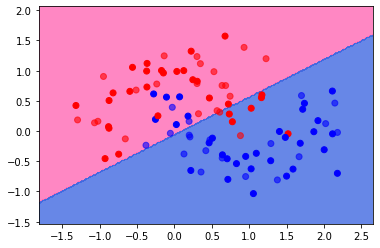

In [0]:
X, y = make_moons(noise=0.q, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.6,random_state=0)
lr = LogisticRegression()
lr.fit(X_train,y_train)
print(lr.score(X_test,y_test))
res_plot(model_retrain, X, y, X_train, X_test, y_train, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7


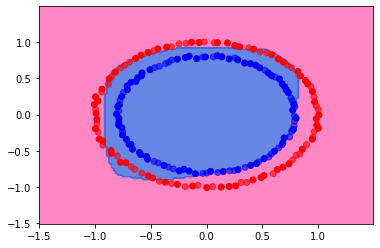

In [0]:
from sklearn.neural_network import MLPClassifier
X, y = make_circles(n_samples = 200 , noise=0.01, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.6,random_state=0)
lr = MLPClassifier(learning_rate="adaptive")
lr.fit(X_train,y_train)
print(lr.score(X_test,y_test))
res_plot(lr.predict, X, y, X_train, X_test, y_train, y_test)

In [0]:
X,y = torch.from_numpy(X),torch.from_numpy(y)
f = model.f_before_Linear(X)
np_f = f.cpu().detach().numpy()
label = y.cpu().numpy()

ExNN = LogisticRegression()
ExNN.fit(np_f,label)
ExNN.score(np_f,label)
res_plot(clf.predict, X, y, X_train, X_test, y_train, y_test)